<h3><b>Train a Neural Machine Translation model using attention mechanism to enhance it's performance.</b></h3>

<h3><i>Step no.0: setup</i></h3>

In [1]:
#   If using colab:
#       Connect to a GPU run time .
#       Mount to drive.
#       Change the current active directory to project folder.


project_folder = "/content/drive/MyDrive/Colab\ Notebooks/Persian\ to\ English\ NMT\ with\ Attention"
%cd {project_folder}
%ls -l

/content/drive/MyDrive/Colab Notebooks/Persian to English NMT with Attention
total 77
drwx------ 4 root root  4096 Nov 22 12:41 nmt/
drwx------ 2 root root  4096 Nov 26 17:58 tokenizers/
-rw------- 1 root root 70369 Nov 26 18:13 train_nmt_model.ipynb


In [2]:
# Install tensorflow_text which is required for text processing
!pip install "tensorflow-text==2.8.*"

"""TensorFlow Text provides a collection of text related classes
and ops ready to use with TensorFlow 2.0. The library can perform
the preprocessing regularly required by text-based models, and 
includes other features useful for sequence modeling not provided 
by core TensorFlow"""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'TensorFlow Text provides a collection of text related classes\nand ops ready to use with TensorFlow 2.0. The library can perform\nthe preprocessing regularly required by text-based models, and \nincludes other features useful for sequence modeling not provided \nby core TensorFlow'

In [3]:
# Import libs
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from nmt.dataset import Hyperparameters
from nmt.dataset import get_anki_dataset
from nmt.model import Translator
from nmt.model import masked_loss, masked_acc

In [4]:
# define a hyper-parametrs object to hold required hyperparamters in on place.
hp = Hyperparameters(
    batch_size=32,
    units=512,
    num_heads=1,
    vocab_size=15000,
)

for p, v in vars(hp).items():
    print(f"{p:15} : {v}")

batch_size      : 32
units           : 512
num_heads       : 1
vocab_size      : 15000


<h4><i>Step no.1: Load and explore dataset.</i></h4>

In [5]:
# load dataset
print("loading dataset and tokenizers ...", end=" ")
dataset, (inputs_tokenizer, targets_tokenizer) = get_anki_dataset(
    vocab_size=hp.vocab_size, 
    batch_size=hp.batch_size
)
print("done .")

loading dataset and tokenizers ... done .


In [6]:
# a quick glance at dataset shape
for inputs, outputs in dataset.take(1):
    enc_input, dec_input = inputs['enc_inputs'], inputs["dec_inputs"]
    print(f"encoder input shape:{'':3} {enc_input.shape}")
    print(f"decoder input shape:{'':3} {dec_input.shape}")
    print(f"output/target shape:{'':3} {outputs.shape}")

encoder input shape:    (32, 33)
decoder input shape:    (32, 36)
output/target shape:    (32, 36)


In [7]:
# save the tokenizers config to disk, so we can build a same tokenizer as these later.
tokenizers_path = os.path.join(".", "tokenizers")
if not os.path.exists(tokenizers_path):
    os.mkdir(tokenizers_path)

# save tokenizers config
inputs_tokenizer_filepath = os.path.join(tokenizers_path, "inputs_tokenizer_config.pkl")
targets_tokenizer_filepath = os.path.join(tokenizers_path, "targets_tokenizer_config.pkl")
pickle.dump({'config': inputs_tokenizer.get_config(), 'weights': inputs_tokenizer.get_weights()}, 
            open(inputs_tokenizer_filepath, "wb"))
pickle.dump({'config': targets_tokenizer.get_config(), 'weights': targets_tokenizer.get_weights()}, 
            open(targets_tokenizer_filepath, "wb"))
# =================================================== #


# it's better to save the vocabularies too.
input_vocabs_filepath = os.path.join(tokenizers_path, "inputs_vocab.npy")
target_vocabs_filepath = os.path.join(tokenizers_path, "targets_vocab.npy")

inputs_vocab = np.array(inputs_tokenizer.get_vocabulary())
targets_vocab = np.array(targets_tokenizer.get_vocabulary())

with open(input_vocabs_filepath, 'wb') as file:
    np.save(file, inputs_vocab)
with open(target_vocabs_filepath, 'wb') as file:
    np.save(file, targets_vocab)
    # =================================================== #

In [8]:
## HOW TO LOAD 
## 1. tokenizers

#from_disk = pickle.load(open(inputs_tokenizer_filepath, "rb"))
#inputs_tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
#inputs_tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))   # call with sume dummy data
#inputs_tokenizer.set_weights(from_disk['weights'])

#from_disk = pickle.load(open(targets_tokenizer_filepath, "rb"))
#targets_tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
#targets_tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))   # call with sume dummy data
#targets_tokenizer.set_weights(from_disk['weights'])

## 2. load vocabs
#with open(input_vocabs_filepath, 'rb') as file:
#    inputs_vocab = np.load(file)

#with open(targets_tokenizer_filepath, 'rb') as file:
#    targets_vocab = np.load(file)

## the first part is sufficent for loading tokenizers.

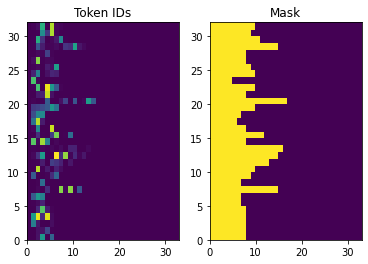

In [9]:
plt.subplot(1, 2, 1)
plt.pcolormesh(enc_input)
_ = plt.title("Token IDs")

plt.subplot(1, 2, 2)
plt.pcolormesh(enc_input != 0)
_ = plt.title("Mask")

In [10]:
# Define a function to convert a tokenized sentence into text

source_vocabs = np.array(inputs_tokenizer.get_vocabulary())
target_vocabs = np.array(targets_tokenizer.get_vocabulary())

def convert_tokens_to_text(tokens, lang="persian"):
    tokens = tokens.numpy() if isinstance(tokens, tf.RaggedTensor) else tokens
    if lang == "persian":
        return ' '.join(source_vocabs[tokens][0])
    return ' '.join(target_vocabs[tokens][0])

<h3><i>Step no.2: Build the Model.</i></h3>

In [11]:
# Build the Model

nmt_model = Translator(
    inputs_tokenizer,
    targets_tokenizer,
    units=hp.units,
    attn_num_heads=hp.num_heads,
)

In [12]:
# Compile the Model
nmt_model.compile(optimizer="adam", loss=masked_loss, 
                  metrics=[masked_loss, masked_acc])

In [13]:
history = nmt_model.fit(
    dataset.repeat(),
    epochs=110,
    steps_per_epoch = 100,
)

Epoch 1/110
100/100 [==============================] - 15s 35ms/step - loss: 4.7555 - masked_loss: 4.7553 - masked_acc: 0.2977
Epoch 2/110
100/100 [==============================] - 3s 33ms/step - loss: 3.2134 - masked_loss: 3.2182 - masked_acc: 0.4298
Epoch 3/110
100/100 [==============================] - 3s 33ms/step - loss: 2.1971 - masked_loss: 2.2023 - masked_acc: 0.5522
Epoch 4/110
100/100 [==============================] - 3s 33ms/step - loss: 1.3603 - masked_loss: 1.3549 - masked_acc: 0.6906
Epoch 5/110
100/100 [==============================] - 3s 33ms/step - loss: 0.8034 - masked_loss: 0.8035 - masked_acc: 0.8030
Epoch 6/110
100/100 [==============================] - 3s 34ms/step - loss: 0.4745 - masked_loss: 0.4740 - masked_acc: 0.8810
Epoch 7/110
100/100 [==============================] - 3s 33ms/step - loss: 0.3054 - masked_loss: 0.3061 - masked_acc: 0.9240
Epoch 8/110
100/100 [==============================] - 5s 46ms/step - loss: 0.2399 - masked_loss: 0.2406 - masked_acc

<h3><i>Step no.3: Plot the loss and accuracy history.</i></h3>

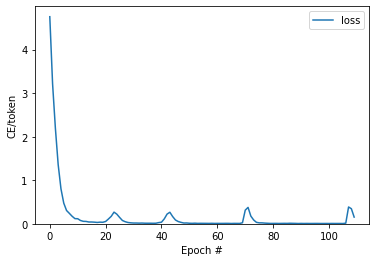

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

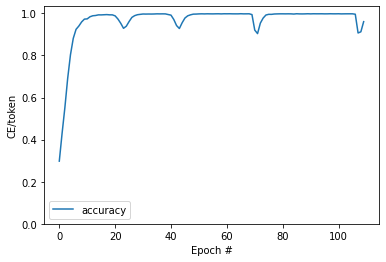

In [15]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

<h3><i>Step no.4: Evaluate the model</i></h3>

In [16]:
texts = ["سلام . حالت چطوره", "با تو موافقم", "من داشتم قدم می زدم", "دوست من یک دکتر است"]

for t in texts:
    result = nmt_model.translate([t])
    translated = result[0].numpy().decode()
    print(f"{t:10}: {translated}")
    print()

سلام . حالت چطوره: hello how how how how hello how how how hello how how how hello how how how hello how how how hello how how how hello how how how hello how how how hello how how how hello how how how hello how how how hello how how how hello

با تو موافقم: agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with agree with

من داشتم قدم می زدم: i got running from house from terrified than terrified got left i got running from my house got running got terrified . terrified got running got terrified . terrified got running left . terrified than terrified got terrified . 

دوست من یک دکتر است: my a is a is a is a is a is a is a is a is a is a is a is a is a is a is a is a is a is a is a is a is a is a is a is a is a

